In [1]:
import pandas as pd
import os
import re
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

## LOAD DATA

In [2]:
df = pd.read_parquet("../data/de_poems.parquet")
df = df.astype({"title": "string", "text": "string", "author": "string", "creation": "int64"})
df.dtypes

title       string[python]
text        string[python]
author      string[python]
creation             int64
dtype: object

## PREPROCESS THE DATA

In [3]:
def preprocess_text(text: str) -> list[str]:
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # remove punctuation
    tokens = text.split()
    return tokens

df["century"] = (df["creation"] // 100) + 1
df["tokens"] = df["text"].apply(preprocess_text)
df

,title,text,author,creation,century,tokens
0,94.Wieder Geburt,"Gebohrn, und wiederumb, o Mensch, gebohren wer...","Czepko von Reigersfeld, Daniel",1632,17,"[gebohrn, und, wiederumb, o, mensch, gebohren,..."
1,56.Liebe ist der Grund der Welt,"Es suchte niemand Gott, liegt er gleich unterm...","Czepko von Reigersfeld, Daniel",1632,17,"[es, suchte, niemand, gott, liegt, er, gleich,..."
2,7.Gott ergebene Seele,"Die ist in Gott, und Gott der ist zugleich in ...","Czepko von Reigersfeld, Daniel",1632,17,"[die, ist, in, gott, und, gott, der, ist, zugl..."
3,2.Biß auf den Mund,"Alles, was ich seh an dir, Deiner Stellung, Wo...","Czepko von Reigersfeld, Daniel",1632,17,"[alles, was, ich, seh, an, dir, deiner, stellu..."
4,50.Ohne Rache,"Der Weise sucht, ob du ihn hundertmal erschlag...","Czepko von Reigersfeld, Daniel",1632,17,"[der, weise, sucht, ob, du, ihn, hundertmal, e..."
...,...,...,...,...,...,...
71565,An Herrn Hofrath C*,"Jhr Liebling, unerquickt vom güldnen Sonnenlic...","Uz, Johann Peter",1758,18,"[jhr, liebling, unerquickt, vom, gldnen, sonne..."
71566,An Herrn Hofrath C*,Sieh! Opitz steht voran: Sein Geist kennt kein...,"Uz, Johann Peter",1758,18,"[sieh, opitz, steht, voran, sein, geist, kennt..."
71567,An Herrn Hofrath C*,Kann ein verblendet Volk die Thorheit höher tr...,"Uz, Johann Peter",1758,18,"[kann, ein, verblendet, volk, die, thorheit, h..."
71568,An Herrn Hofrath C*,"Wie, wann der schwarzumwölkte Süd, Auf dessen ...","Uz, Johann Peter",1758,18,"[wie, wann, der, schwarzumwlkte, sd, auf, dess..."


## Word2Vec model training & text vectorization

In [4]:
#w2v_model = Word2Vec(sentences=df["tokens"], vector_size=500, window=25, min_count=2, workers=20, epochs=30, seed=42)
w2v_model = Word2Vec(sentences=df["tokens"], vector_size=750, window=25, min_count=2, workers=20, epochs=50, seed=42)

In [5]:
"""def vectorize(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)"""
def vectorize(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size * 2)
    vectors = np.array(vectors)
    mean_vec = vectors.mean(axis=0)
    max_vec = vectors.max(axis=0)
    return np.concatenate([mean_vec, max_vec])

df["vector"] = df["tokens"].apply(lambda tokens: vectorize(tokens, w2v_model))

## LOGISTIC REGRESSION TRAINING

In [6]:
X = np.stack(df["vector"].values)
y = df["century"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

In [7]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1 = report['weighted avg']['f1-score']
accuracy = report['accuracy']
# for ROC AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
roc_auc = roc_auc_score(y_test_binarized, clf.predict_proba(X_test), average='macro', multi_class='ovr')

              precision    recall  f1-score   support

          11       0.28      0.49      0.36        55
          13       0.60      0.50      0.55        18
          14       0.67      0.80      0.73       189
          16       0.81      0.88      0.84       210
          17       0.91      0.89      0.90      4032
          18       0.66      0.75      0.70      2880
          19       0.87      0.73      0.80      6476
          20       0.31      0.74      0.44       454

    accuracy                           0.78     14314
   macro avg       0.64      0.72      0.67     14314
weighted avg       0.82      0.78      0.79     14314



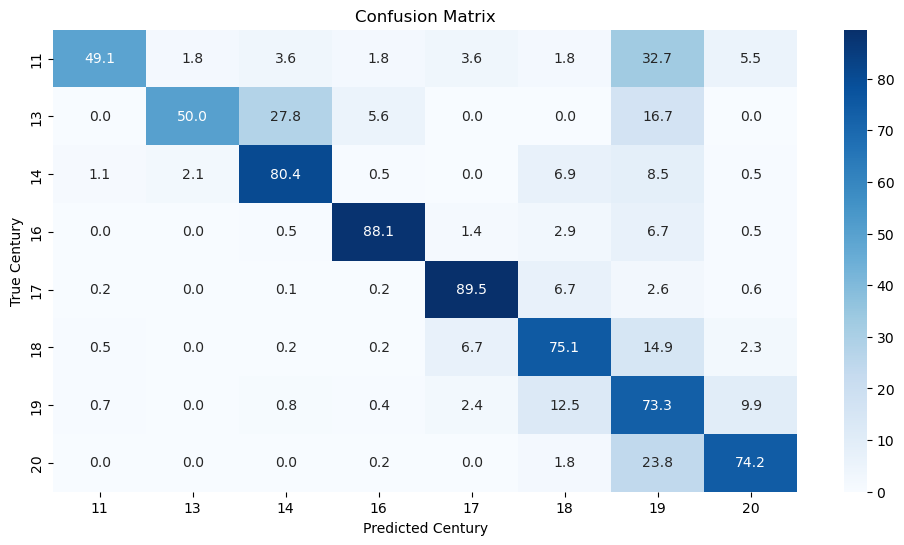

In [8]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
cm_percent = cm * 100
plt.figure(figsize=(12, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Century")
plt.xlabel("Predicted Century")
plt.show()

In [11]:

BENCHMARK_TABLE = "../../class_bench.parquet"
benchmark = pd.read_parquet(BENCHMARK_TABLE)
benchmark.loc[("Word2Vec", "Logistic Regression"), ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC"]] = [
    avg_recall, avg_f1, avg_precision, accuracy, roc_auc
]
benchmark.to_parquet(BENCHMARK_TABLE, index=True)

In [12]:
benchmark

Accuracy  Avg Precision  Avg Recall  \
Encoding Model                                                             
TF-IDF   Logistic Regression         0.803689       0.828462    0.803689   
         Feedforward Neural Network  0.870896       0.869331    0.870896   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.776513       0.776507    0.776513   
Word2Vec Logistic Regression         0.784547       0.816938    0.784547   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.717968       0.793872    0.717968   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.814028       0.809732    0.814028   
         Multi-Layer Perceptron      0.840506       0.837564    0.840506   

                                     Avg F1-Score   Avg AUC  \
Encoding Model                                                
TF-IDF   Logistic Regression             0.812189  0.969342   
         Feedforward Neural Network      0.868993  0.980472   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.759780  0.927325   
Word2Vec Logistic Regression             0.794427  0.959170   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.730375  0.965358   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.809036  0.946552   
         Multi-Layer Perceptron          0.838563  0.983007   

                                     Avg Training time (m)  
Encoding Model                                              
TF-IDF   Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
Word2Vec Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
         Multi-Layer Perceptron                        0.0